In [92]:
import os
from dotenv import load_dotenv
import sqlalchemy
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_period_transactions
import seaborn as sns

In [93]:
# load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

In [94]:
# Create database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [95]:
# function to create df
def create_df(table_name):
    try:
        connection = engine.connect() 
        query = f'''
        SELECT 
            *
        FROM
            {table_name} 
        '''
        
        df = pd.read_sql(query, con=connection)
        if table_name=="users":
            df = df.rename(columns={"user_id": "cust_id"})
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback() 
    finally:
        connection.close()  

def create_full_table():
    full_table = create_df('online_sales')
    tables = {'products': 'product_id',
              'users': 'cust_id',
              'ratings': 'product_id'
              }
    for key, value in tables.items():
        df = create_df(key)
        full_table = pd.merge(full_table, df, on=value, how='inner')
    
    full_table['total_price'] = np.where(
    full_table['coupon_status'] == 'Used',
    full_table['quantity'] * full_table['actual_price'] * (1 - full_table['discount_percentage_x']),
    full_table['quantity'] * full_table['actual_price']
    )
    full_table['date'] = pd.to_datetime(full_table['date'], errors='coerce')
    return full_table

### CLTV Prediction 
CLTV =BG/NBD Model * Gamma Gamma Submodel


### BG-NBD Model (Beta Geometric/Negative Binomial Distribution)

To predict customer lifetime value (CLTV) metrics, specifically the expected purchases for individual customers and the overall expected transactions for the company in the next month.  

The BG/NDB Model probabilistically models two processes for the Expected Number of Transactions:

Transaction Process (Buy) + Dropout Process (Till you die)  

As long as the Transaction Process is active, a poisson distribution is used to determine how many transactions a client will complete in a given amount of time. As long as a client is alive, it will continue to randomly scatter around its transaction rate.

In [96]:
def bg_nbd():
    today_date = dt.datetime(2020, 1, 1)
    sales = create_full_table()

    cltv_prediction = sales.groupby('cust_id').agg({
        'date': [min, max],
        'transaction_id': 'nunique', 
        'total_price': 'sum',
    })

    cltv_prediction.columns = ['earliest_date', 'latest_date', 'frequency', 'monetary']
    
    cltv_prediction['recency'] = (cltv_prediction['latest_date'] - cltv_prediction['earliest_date']).dt.days
    cltv_prediction["monetary"] = cltv_prediction["monetary"] / cltv_prediction["frequency"]
    cltv_prediction['T'] = (today_date - cltv_prediction['earliest_date']).dt.days

    # he BG/NBD model assumes that customers have already made some repeat purchases to establish a purchasing pattern. 
    # When frequency is 0, there isn’t enough data for the model to make reliable predictions about future transactions hence, remove frequency = 0
    cltv_prediction = cltv_prediction[(cltv_prediction["frequency"] > 1)]
    # some users have multiple transactions on only one day
    cltv_prediction = cltv_prediction[(cltv_prediction["recency"] > 0)]

    cltv_prediction["T"] = cltv_prediction["T"] / 7
    cltv_prediction["recency"] = cltv_prediction["recency"] / 7

    cltv_prediction = cltv_prediction.drop(columns=['earliest_date', 'latest_date'])

    return cltv_prediction

cltv_prediction = bg_nbd()
print(cltv_prediction.head())

         frequency     monetary    recency          T
cust_id                                              
12347           31   434.135516  31.857143  40.428571
12348            8  3677.904625  17.000000  27.571429
12370           44  3091.433205   4.285714  31.428571
12377           37  3475.751216  19.857143  25.714286
12383           39   333.387641  10.285714  24.571429


In [97]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"])
cltv_prediction[["frequency", "recency", "T"]].describe()

,frequency,recency,T
count,734.000000,734.000000,734.000000
mean,27.444142,18.388283,34.789607
std,31.499869,14.766543,13.081589
min,2.000000,0.142857,0.285714
25%,10.250000,4.000000,26.857143
50%,19.000000,17.285714,38.000000
75%,34.000000,29.428571,45.821429
max,328.000000,51.142857,52.142857


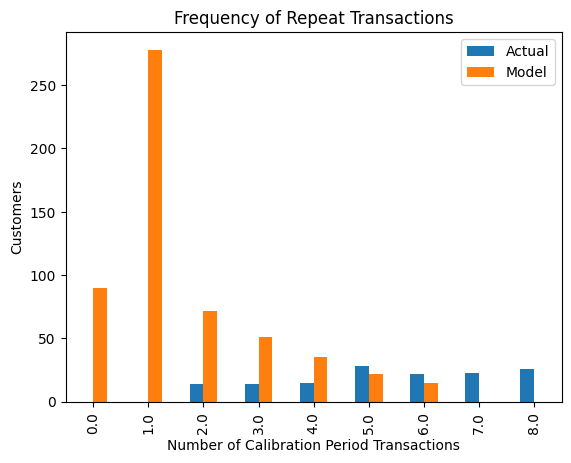

In [98]:
plot_period_transactions(bgf)
plt.show()

We see very high predictions for low frequencies especially for those with only 1 repeat transaction, overestimating the number of customers who fall into these categories. However, for transaction counts of 3 and higher, the actual predicted values appear closed, though there are still some differences at frequencies of 7-8. Hence, we have to keep in mind that the model may not be entirely accurate for customers with infrequent purchases. This could lead to biased CLTV estimates for these customer segments.

top 10 customers and their expected number of purchase in the following week: cust_id
16745    6.051714
14606    5.718155
14438    4.857428
15808    2.707162
17315    1.774204
13488    1.533808
14462    1.504347
13050    1.453608
13069    1.440493
12567    1.402367
dtype: float64


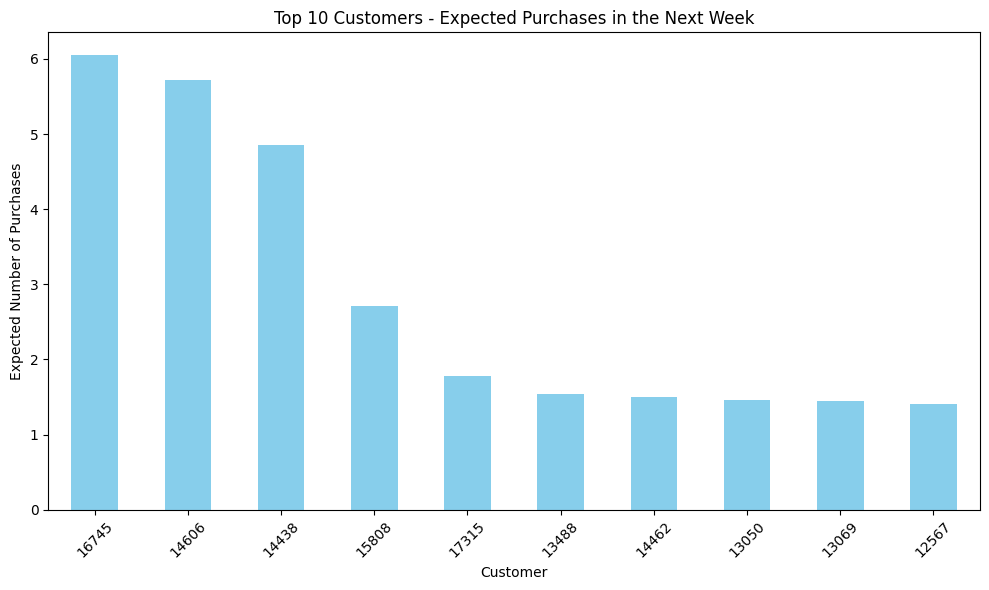

In [99]:
# find the top 10 customers who will purchase in the next 1 week
def top_customers(n):
    top_customers_n_week = bgf.conditional_expected_number_of_purchases_up_to_time(n,  # number of weeks
                                                            cltv_prediction["frequency"],
                                                            cltv_prediction["recency"],
                                                            cltv_prediction["T"]).sort_values(ascending=False).head(10)
    return top_customers_n_week

print(f"top 10 customers and their expected number of purchase in the following week: {top_customers(1)}")

plt.figure(figsize=(10, 6))
top_customers(1).plot(kind='bar', color='skyblue')
plt.title('Top 10 Customers - Expected Purchases in the Next Week')
plt.xlabel('Customer')
plt.ylabel('Expected Number of Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Expected number of transactions in the next month: [np.float64(102.07699465844786), np.float64(200.57089839169873), np.float64(296.6394464423023), np.float64(390.727269584124)]


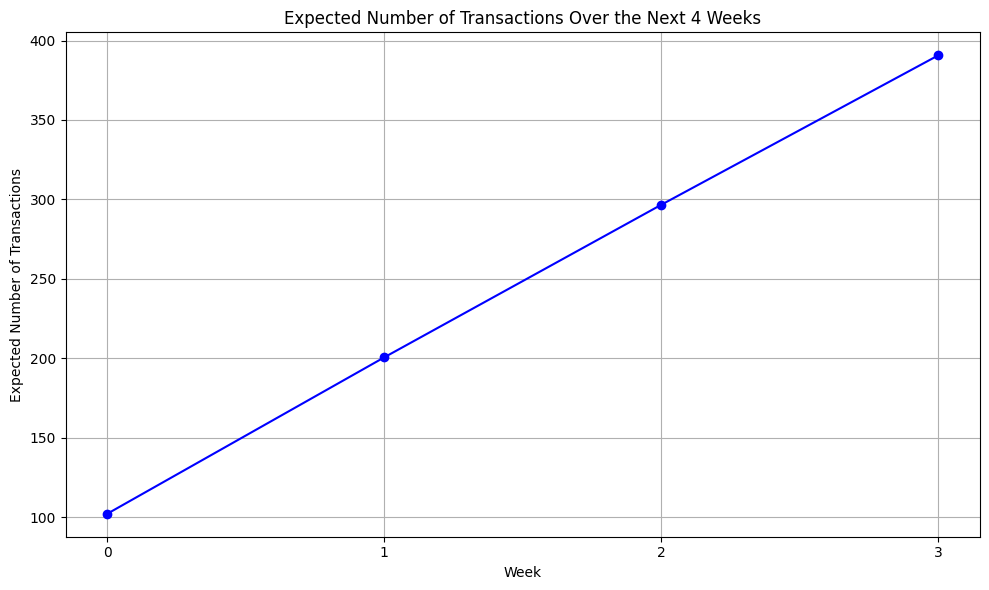

In [100]:
# number of transactions expected by the company in a month
def expected_num_transactions(num_weeks):
    res = []
    weeks = []
    for week in range(num_weeks):
        num_transactions_in_week = bgf.predict(week+1, cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"]).sum()
        res.append(num_transactions_in_week)
        weeks.append(week)
    return weeks, res

# get the expected number of transactions for the next 4 weeks
num_weeks = 4 # can be changed
weeks, expected_num_transactions_in_next_4_weeks = expected_num_transactions(num_weeks)
print(f"Expected number of transactions in the next month: {expected_num_transactions_in_next_4_weeks}")

plt.figure(figsize=(10, 6))
plt.plot(weeks, expected_num_transactions_in_next_4_weeks, marker='o', color='b', linestyle='-')
plt.title('Expected Number of Transactions Over the Next 4 Weeks')
plt.xlabel('Week')
plt.ylabel('Expected Number of Transactions')
plt.xticks(weeks)
plt.grid(True)
plt.tight_layout()
plt.show()

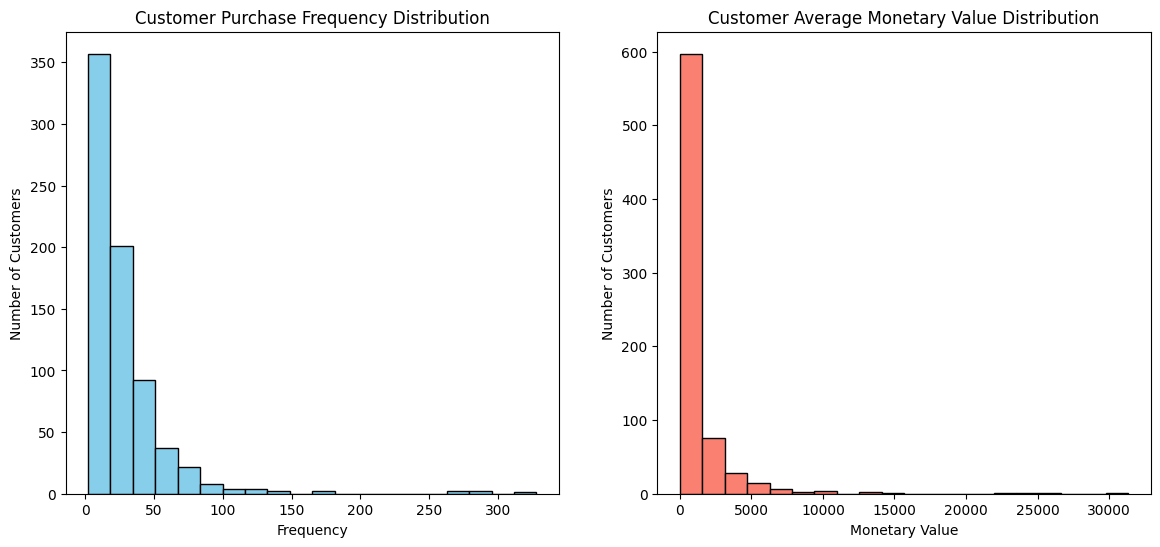

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(cltv_prediction['frequency'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title("Customer Purchase Frequency Distribution")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Number of Customers")

ax2.hist(cltv_prediction['monetary'], bins=20, color='salmon', edgecolor='black')
ax2.set_title("Customer Average Monetary Value Distribution")
ax2.set_xlabel("Monetary Value")
ax2.set_ylabel("Number of Customers")

plt.show()


### Gamma-Gamma Model

It is used to estimate how much profit a customer can generate on average per trade. The monetary value of a customer is randomly distributed around the average of the transaction values. The average transaction value may change between users over time, but not for a single user. The average transaction value is gamma distributed among all customers.

In [102]:
def gamma_gamma(df):
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(df["frequency"], df["monetary"])
    return ggf

ggf = gamma_gamma(cltv_prediction)

# Find average profit
cltv_prediction["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_prediction["frequency"], cltv_prediction["monetary"])

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_prediction["frequency"],
                                   cltv_prediction["recency"],
                                   cltv_prediction["T"],
                                   cltv_prediction["monetary"],
                                   time=3, # 3 months, how many months account do you want?
                                   freq="W", # frequency information of T
                                   discount_rate=0.01)
cltv = cltv.reset_index()

cltv_final = cltv_prediction.merge(cltv, on="cust_id", how="left")
cltv_final.sort_values(by="clv", ascending=True).head(10)


,cust_id,frequency,monetary,recency,T,expected_average_profit,clv
673,17850,177,994.922887,3.571429,52.142857,996.150248,6.782665e-200
567,17059,69,246.638174,0.142857,45.428571,247.456810,2.242842e-166
606,17337,139,1252.239532,0.142857,2.571429,1254.201049,9.070724e-164
609,17341,65,2801.427123,0.142857,39.142857,2810.763596,3.405581e-151
380,15464,68,2619.726971,0.142857,23.000000,2628.074682,1.919669e-142
469,16222,71,346.351268,0.142857,9.714286,347.449239,7.603049e-123
514,16686,51,161.997961,0.142857,26.000000,162.748896,1.236106e-109
293,14729,42,452.534167,0.142857,51.285714,454.939785,5.300223e-102
598,17284,49,950.341837,0.142857,21.428571,954.593264,3.175291e-100
208,14049,57,796.113228,0.142857,9.285714,799.182538,2.864873e-96


In [103]:
cltv_final["segment"]=pd.qcut(cltv_final["clv"],4,labels=["Low","Medium","High","Top"])

cltv_final.groupby("segment").agg({"count","mean","sum"})

cust_id                        frequency                  monetary  \
          count          mean      sum     count       mean   sum    count   
segment                                                                      
Low         184  15430.255435  2839167       184  34.788043  6401      184   
Medium      183  15305.333333  2800876       183  23.781421  4352      183   
High        183  15305.459016  2800899       183  20.426230  3738      183   
Top         184  15301.771739  2815526       184  30.722826  5653      184   

                                    recency  ...                  T  \
                mean            sum   count  ...          sum count   
segment                                      ...                      
Low      1191.217745  219184.065024     184  ...   702.285714   184   
Medium    818.933941  149864.911118     183  ...  2614.857143   183   
High      907.627164  166095.771023     183  ...  4189.714286   183   
Top      1929.118646  354957.830789     184  ...  5990.142857   184   

                                expected_average_profit               \
              mean          sum                   count         mean   
segment                                                                
Low      30.302795  5575.714286                     184  1204.762043   
Medium   34.086651  6237.857143                     183   829.945912   
High     37.013271  6773.428571                     183   939.435598   
Top      37.763975  6948.571429                     184  1990.942417   

                         clv                              
                   sum count          mean           sum  
segment                                                   
Low      221676.215887   184  1.155088e-10  2.125362e-08  
Medium   151880.101898   183  1.454081e-01  2.660969e+01  
High     171916.714466   183  1.029490e+02  1.883966e+04  
Top      366333.404715   184  8.199449e+03  1.508699e+06  

[4 rows x 21 columns]

In [104]:
# Custom bin ranges
bins = [0, 100, 1000, 10000, float('inf')]
labels = ["Low", "Medium", "High", "Top"]

# Segment based on custom bins
cltv_final['clv_segment'] = pd.cut(cltv_final['clv'], bins=bins, labels=labels)
print(cltv_final[['cust_id', 'clv', 'clv_segment']])

     cust_id           clv clv_segment
0      12347  1.317686e+02      Medium
1      12348  4.109702e+03        High
2      12370  2.086738e-32         Low
3      12377  2.538923e+02      Medium
4      12383  6.089474e-10         Low
..       ...           ...         ...
729    18239  5.805960e+03        High
730    18245  2.109527e+02      Medium
731    18260  7.667185e-01         Low
732    18269  1.577320e+02      Medium
733    18283  2.317455e-12         Low

[734 rows x 3 columns]


clv_segment
Low       485
Medium     99
High      118
Top        32
Name: count, dtype: int64


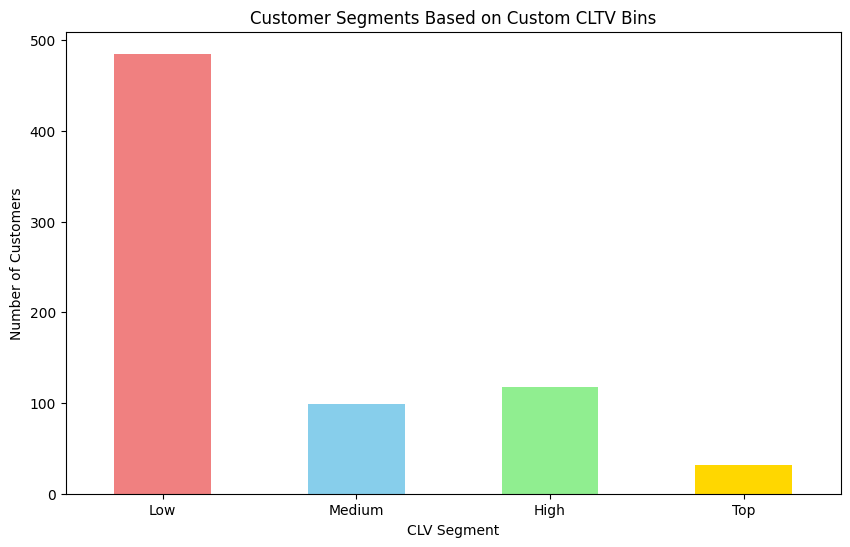

In [105]:
# Count the number of customers in each segment
segment_counts = cltv_final['clv_segment'].value_counts().reindex(labels)
print(segment_counts)
# Plot the segments
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color=['lightcoral', 'skyblue', 'lightgreen', 'gold'])
plt.title("Customer Segments Based on Custom CLTV Bins")
plt.xlabel("CLV Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()

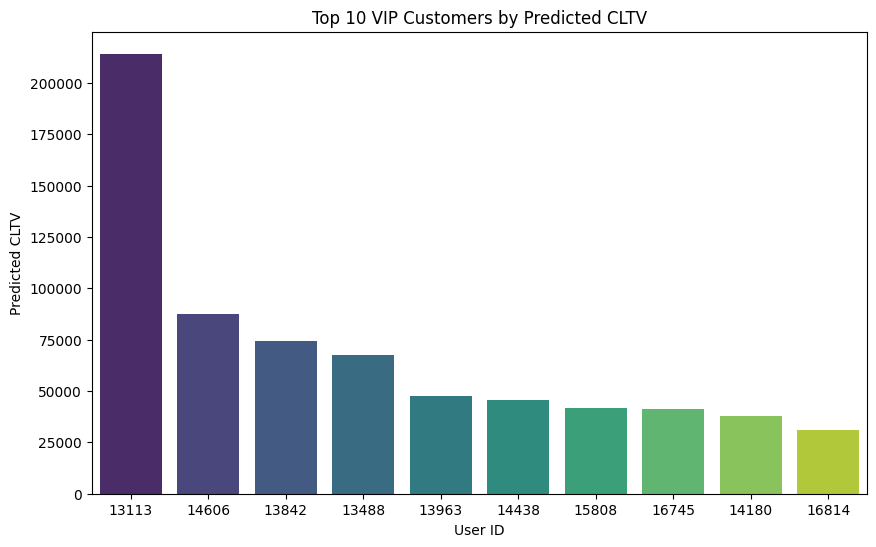

In [106]:
top_vip_customers = cltv_final[['cust_id', 'clv']].sort_values(by='clv', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='cust_id', y='clv', data=top_vip_customers, 
            palette='viridis', order=top_vip_customers.sort_values('clv', ascending=False)['cust_id'])
plt.title('Top 10 VIP Customers by Predicted CLTV')
plt.xlabel('User ID')
plt.ylabel('Predicted CLTV')
plt.show()

# Evaluation against CLTV Calculation

Predictive CLTV models, like BG/NBD and Gamma-Gamma, are typically conservative and assume that not all customers will continue to purchase at the same frequency or value as they have historically hence, the predicted CLTV is often lower than the actual calculated CLTV.  

Predictive CLTV models usually assume a degree of customer churn and purchase decay, meaning that over time, some customers will stop purchasing, and the frequency or value of purchases may decrease.  

For instance, the BG/NBD model incorporates probabilities of "dropout" for each customer, inherently leading to more conservative CLTV predictions.  

Additionally, with limited historical data or low-frequency customers, predictive models have less data to accurately estimate long-term behavior, often resulting in conservative (lower) predictions.  

Models prioritize repeat purchasing behavior, which often reduces predicted CLTV for customers with sporadic or low-frequency purchases.